# KiryatGat

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
df_kg = pd.read_excel('/content/drive/Shareddrives/205/data_after_prepro_2.xlsx')
df_kg.head()

,address,dispatch_code,age,evacuation_target,medical_team_code,dispatch_time,weekday,humidity,temperature,temp_max,...,o3,no2,es_code,is_holiday,season,day_night,season_Autumn,season_Spring,season_Summer,season_Winter
0,שדרות צה''ל,1-מחלה מבוגר,62.0,ברזילי- אשקלון,פצע/דימום שלא כתוצאה מטראומה,2024-04-08 09:18:36.901,2,46,23.2,23.4,...,45.0,5.0,34,0,Spring,0,False,True,False,False
1,נתיבות שלום,1-מחלה מבוגר,43.0,שיבא תל השומר,חבלת ראש,2024-04-08 09:36:15.142,2,43,23.3,23.8,...,45.0,5.0,32,0,Spring,0,False,True,False,False
2,שבטה,1-מחלה מבוגר,77.0,אסותא ציבורי אשדוד,אצירת שתן,2024-04-08 09:41:59.210,2,43,23.3,23.8,...,45.0,5.0,37,0,Spring,0,False,True,False,False
3,נחל גוברין,6-פציעה אחרת,1.0,ברזילי- אשקלון,חבלת פנים,2024-04-08 09:58:49.530,2,42,23.1,23.3,...,45.0,5.0,26,0,Spring,0,False,True,False,False
4,שדרות מלכי ישראל,1-מחלה מבוגר,56.0,ברזילי- אשקלון,כאב/לחץ בחזה שאינו ממקור לבבי,2024-04-08 12:21:11.156,2,47,24.6,24.8,...,45.0,5.0,35,0,Spring,0,False,True,False,False


In [ ]:
df_kg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13553 entries, 0 to 13552
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   address            13553 non-null  object        
 1   dispatch_code      13553 non-null  object        
 2   age                13553 non-null  float64       
 3   evacuation_target  13553 non-null  object        
 4   medical_team_code  13553 non-null  object        
 5   dispatch_time      13553 non-null  datetime64[ns]
 6   weekday            13553 non-null  int64         
 7   humidity           13553 non-null  object        
 8   temperature        13553 non-null  object        
 9   temp_max           13553 non-null  object        
 10  rain_mm            13553 non-null  object        
 11  temp_min           13553 non-null  object        
 12  pm25               13177 non-null  float64       
 13  o3                 13443 non-null  float64       
 14  no2   

### model GPT

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === 1. Load and clean data ===
df_work = df_kg.copy()
df_work.drop_duplicates(inplace=True)
df_work = df_work.dropna()
df_work["medical_team_code"] = df_work["medical_team_code"].astype(str).str.strip()

# Remove rows with empty strings in object columns
for col in df_work.select_dtypes(include='object').columns:
    if (df_work[col] == '').any():
        df_work = df_work[df_work[col] != '']

# === 2. Filter relevant medical cases ================================================================================================================================
keywords = ["לב", "לבבי", "חזה", "נשימה", "COPD", "ברדיקרדיה"]
pattern = "|".join(keywords)
df_work = df_work[df_work["medical_team_code"].str.contains(pattern, case=False, na=False)]

# === 3. Create time-based features ===
df_work["dispatch_datetime"] = pd.to_datetime(df_work["dispatch_time"])
df_work["datetime_interval"] = df_work["dispatch_datetime"].dt.floor("8H")
df_work["hour"] = df_work["dispatch_datetime"].dt.hour
df_work["dayofweek"] = df_work["dispatch_datetime"].dt.dayofweek

# === 4. Convert numeric weather columns ===
numeric_cols = ["humidity", "temperature", "rain_mm", "pm25", "o3", "no2"]
for col in numeric_cols:
    df_work[col] = pd.to_numeric(df_work[col], errors="coerce")

# === 5. Fill & clean missing values ===
df_work["rain_mm"].fillna(0, inplace=True)
df_work.dropna(subset=["temperature", "humidity"], inplace=True)

# === 6. Add weather-based binary features ===
df_work["is_extreme_heat"] = df_work["temperature"] > 32
df_work["is_extreme_cold"] = df_work["temperature"] < 5
df_work["is_heavy_rain"] = df_work["rain_mm"] > 5
df_work["is_pollution_spike"] = df_work["pm25"] > 75

# === 7. Aggregate per (zone, time interval) ===
agg = df_work.groupby(["es_code", "datetime_interval"]).agg(
    zone_call_count=("es_code", "size"),
    avg_temp=("temperature", "mean"),
    avg_humidity=("humidity", "mean"),
    avg_pm25=("pm25", "mean"),
    avg_o3=("o3", "mean"),
    avg_no2=("no2", "mean"),
    avg_rain=("rain_mm", "mean"),
    is_extreme_heat=("is_extreme_heat", "max"),
    is_extreme_cold=("is_extreme_cold", "max"),
    is_heavy_rain=("is_heavy_rain", "max"),
    is_pollution_spike=("is_pollution_spike", "max"),
    hour=("hour", "mean"),
    dayofweek=("dayofweek", "mean")
).reset_index()

# === 8. Add lag features ===
agg = agg.sort_values(["es_code", "datetime_interval"])
agg["lag_calls_1"] = agg.groupby("es_code")["zone_call_count"].shift(1).fillna(0)

# === 9. Prepare features and target ===
y = agg["zone_call_count"]
X = agg.drop(columns=["zone_call_count", "es_code", "datetime_interval"])

# === 10. Scale numeric features ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === 11. Train/test split (time-based) ===
split_point = int(len(agg) * 0.8)
X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# === 12. Train model ===
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === 13. Evaluation ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


/tmp/ipython-input-2537902325.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_work["datetime_interval"] = df_work["dispatch_datetime"].dt.floor("8H")
/tmp/ipython-input-2537902325.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_work["rain_mm"].fillna(0, inplace=True)


MAE: 0.2315
RMSE: 0.3855
R²: 0.2710


In [ ]:
df_work["medical_team_code"].value_counts()

,count
medical_team_code,
קוצר נשימה,594
כאבים בחזה ממקור לבבי,422
כאב/לחץ בחזה שאינו ממקור לבבי,328
דום לב ונשימה,236
דפיקות לב,93
החמרה ב- COPD,83
בצקת ריאות /החמרה באי ספיקת לב,83
ברדיקרדיה,72
בלבול,58


 96%|=================== | 1619/1690 [00:27<00:01]       

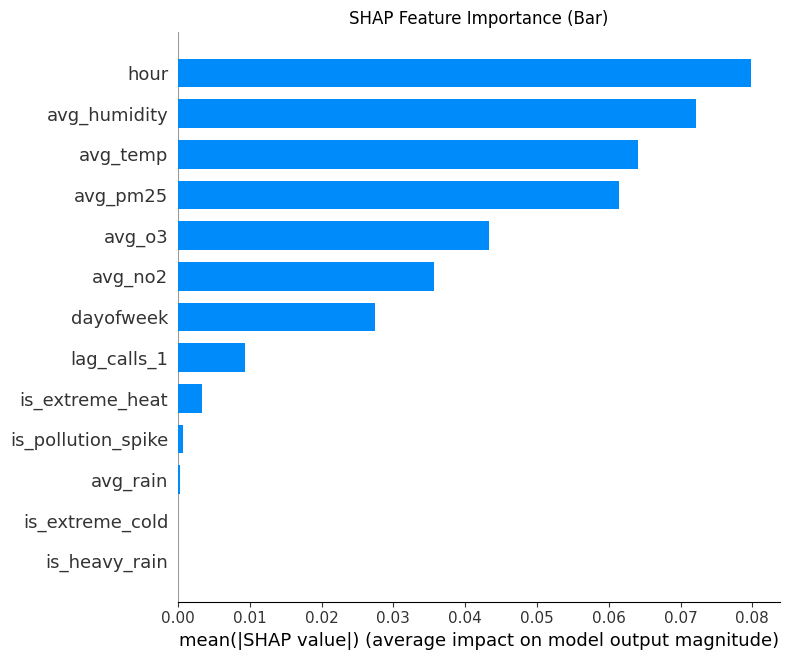

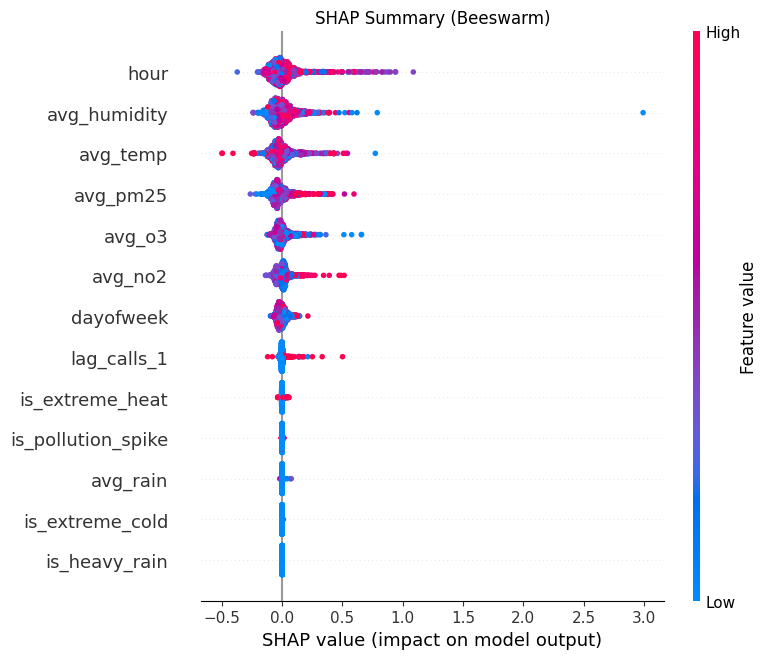

In [ ]:
import matplotlib.pyplot as plt
import shap


# Re-run SHAP with correct feature names
X_df = pd.DataFrame(X_scaled, columns=X.columns)  # Recreate DataFrame with proper column names

# Recalculate SHAP values with updated feature names
explainer = shap.Explainer(model, X_df)
shap_values = explainer(X_df)

# SHAP summary plot (bar) with real feature names
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_df, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar)")
plt.tight_layout()
plt.show()

# SHAP summary plot (beeswarm) with real feature names
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_df, plot_type="dot", show=False)
plt.title("SHAP Summary (Beeswarm)")
plt.tight_layout()
plt.show()


In [ ]:
df_work["es_code"].value_counts()

,count
es_code,
15,382
11,268
12,191
26,154
35,151
21,146
14,125
34,100
31,98


In [ ]:
def explain_zone_forecast_list(model, scaler, df, es_code, conditions):
    """
    Returns forecast explanation as an English bullet list instead of a paragraph.
    """

    # --- same preparation logic as before ---
    if hasattr(scaler, "feature_names_in_"):
        expected_cols = list(scaler.feature_names_in_)
    else:
        expected_cols = [
            "avg_temp","avg_humidity","avg_pm25","avg_o3","avg_no2","avg_rain",
            "is_extreme_heat","is_extreme_cold","is_heavy_rain","is_pollution_spike",
            "hour","dayofweek","lag_calls_1"
        ]

    name_map = {
        "avg_temp": "temperature",
        "avg_humidity": "humidity",
        "avg_pm25": "pm25",
        "avg_o3": "o3",
        "avg_no2": "no2",
        "avg_rain": "rain_mm",
        "hour": "hour",
        "dayofweek": "dayofweek",
        "is_extreme_heat": "is_extreme_heat",
        "is_extreme_cold": "is_extreme_cold",
        "is_heavy_rain": "is_heavy_rain",
        "is_pollution_spike": "is_pollution_spike",
        "lag_calls_1": "lag_calls_1",
    }

    # derive flags if missing
    def derive_flags_if_missing(cond):
        c = cond.copy()
        if "is_extreme_heat" not in c:
            c["is_extreme_heat"] = c.get("temperature", 25) > 32
        if "is_extreme_cold" not in c:
            c["is_extreme_cold"] = c.get("temperature", 25) < 5
        if "is_heavy_rain" not in c:
            c["is_heavy_rain"] = c.get("rain_mm", 0) > 5
        if "is_pollution_spike" not in c:
            c["is_pollution_spike"] = c.get("pm25", 20) > 75
        return c

    conditions = derive_flags_if_missing(conditions)

    if "lag_calls_1" not in conditions or conditions["lag_calls_1"] is None:
        if "datetime_interval" in df.columns:
            tmp = (
                df[df["es_code"] == es_code]
                .groupby("datetime_interval")
                .size()
                .sort_index()
            )
            conditions["lag_calls_1"] = float(tmp.iloc[-1]) if len(tmp) else 0.0
        else:
            conditions["lag_calls_1"] = 0.0

    # build input
    row_vals = []
    for col in expected_cols:
        src = name_map.get(col, None)
        row_vals.append(conditions.get(src, 0.0))
    X_input = pd.DataFrame([row_vals], columns=expected_cols).fillna(0)

    X_scaled = scaler.transform(X_input)
    y_pred = float(model.predict(X_scaled)[0])
    y_pred = max(0.0, y_pred)

    if "datetime_interval" in df.columns:
        zone_hist_counts = (
            df[df["es_code"] == es_code]
            .groupby("datetime_interval")
            .size()
        )
        avg_calls = float(zone_hist_counts.mean()) if len(zone_hist_counts) else 0.0
    else:
        avg_calls = 0.0

    if avg_calls > 0:
        if y_pred >= avg_calls * 2.0:
            risk = "🔴 High"
        elif y_pred >= avg_calls * 1.2:
            risk = "🟠 Medium"
        else:
            risk = "🟢 Low"
    else:
        risk = "🔴 High" if y_pred >= 5 else ("🟠 Medium" if y_pred >= 2 else "🟢 Low")

    # SHAP
    X_scaled_df = pd.DataFrame(X_scaled, columns=expected_cols)
    try:
        explainer = shap.TreeExplainer(model)
        shap_vals = explainer.shap_values(X_scaled_df)
        contributions = list(zip(expected_cols, shap_vals[0]))
        contributions.sort(key=lambda x: abs(x[1]), reverse=True)
        top_factors = [f"{name} ({'+' if val>0 else ''}{val:.2f})" for name, val in contributions[:3]]
    except Exception:
        top_factors = []

    # Build bullet list
    result_list = [
        f"Zone: {es_code}",
        f"Predicted calls: {y_pred:.1f}",
        f"Historical average: {avg_calls:.1f}",
        f"Risk level: {risk}",
        f"Temperature: {conditions['temperature']}°C, Humidity: {conditions['humidity']}%",
        f"PM2.5: {conditions['pm25']}, O3: {conditions['o3']}, NO2: {conditions['no2']}, Rain: {conditions['rain_mm']}mm",
    ]
    if top_factors:
        result_list.append(f"Top contributing factors: {', '.join(top_factors)}")

    return result_list


In [ ]:
# import random

# def random_forecast_explanation(model, scaler, df):
#     # --- 1) Choose random zone ---
#     es_codes = df["es_code"].dropna().unique()
#     es_code = random.choice(es_codes)

#     # --- 2) Generate random conditions ---
#     conditions = {
#         "temperature": random.uniform(0, 42),      # °C
#         "humidity": random.uniform(20, 95),        # %
#         "pm25": random.uniform(5, 150),            # µg/m³
#         "o3": random.uniform(5, 80),               # ppb
#         "no2": random.uniform(5, 60),              # ppb
#         "rain_mm": random.choice([0, random.uniform(0.1, 20)]),
#         "hour": random.randint(0, 23),
#         "dayofweek": random.randint(0, 6),
#         # לפעמים גם lag יוגרל, אחרת יחושב מהיסטוריה
#         "lag_calls_1": random.choice([None, random.randint(0, 5)])
#     }

#     # --- 3) Use the explain function you already have ---
#     paragraph = explain_zone_forecast(model, scaler, df, es_code=es_code, conditions=conditions)

#     return paragraph, es_code, conditions


# # ---------- Example ----------
# text, chosen_zone, conds = random_forecast_explanation(model, scaler, df_work)
# print(f"Random zone: {chosen_zone}")
# print(f"Random conditions: {conds}")
# print("Explanation:")
# print(text)


- Zone: 35
- Predicted calls: 1.4
- Historical average: 1.2
- Risk level: 🟢 Low
- Temperature: 17.1°C, Humidity: 90.3%
- PM2.5: 141.1, O3: 63.9, NO2: 49.6, Rain: 15.0mm
- Top contributing factors: avg_temp (+0.10), avg_no2 (+0.09), avg_humidity (-0.07)


In [ ]:
import random

def random_forecast_explanation_list(model, scaler, df):
    # --- 1) Choose random zone ---
    es_codes = df["es_code"].dropna().unique()
    es_code = random.choice(es_codes)

    # --- 2) Generate random conditions ---
    conditions = {
        "temperature": round(random.uniform(0, 42), 1),   # °C
        "humidity": round(random.uniform(20, 95), 1),     # %
        "pm25": round(random.uniform(5, 150), 1),         # µg/m³
        "o3": round(random.uniform(5, 80), 1),            # ppb
        "no2": round(random.uniform(5, 60), 1),           # ppb
        "rain_mm": round(random.choice([0, random.uniform(0.1, 20)]), 1),
        "hour": random.randint(0, 23),
        "dayofweek": random.randint(0, 6),
        "lag_calls_1": random.choice([None, random.randint(0, 5)])
    }

    # --- 3) Call the explanation function ---
    result_list = explain_zone_forecast_list(model, scaler, df, es_code, conditions)

    return result_list

In [ ]:
# Example: run once
output = random_forecast_explanation_list(model, scaler, df_work)
for line in output:
    print("-", line)


- Zone: 21
- Predicted calls: 1.8
- Historical average: 1.1
- Risk level: 🟠 Medium
- Temperature: 41.8°C, Humidity: 49.8%
- PM2.5: 45.0, O3: 17.0, NO2: 52.0, Rain: 0mm
- Top contributing factors: avg_o3 (+0.32), avg_temp (+0.27), dayofweek (-0.06)


### conect to live data

In [ ]:
import joblib

# Save model and scaler after fitting
joblib.dump(model, "risk_predictor_xgb.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import requests
import pandas as pd
import numpy as np
from datetime import datetime

# === Load pre-trained model and scaler ===
model = joblib.load("risk_predictor_xgb.pkl")
scaler = joblib.load("scaler.pkl")

app = FastAPI(title="Live Emergency Risk Prediction")

# === Define manual weather request format (optional use) ===
class WeatherRequest(BaseModel):
    es_code: str
    temperature: float
    humidity: float
    pm25: float = None
    o3: float = None
    no2: float = None
    rain_mm: float
    hour: int
    dayofweek: int
    lag_calls_1: float

# === Helper function: classify risk level based on prediction ===
def classify_risk(predicted: float) -> str:
    if predicted >= 5:
        return "🔴 High"
    elif predicted >= 2:
        return "🟠 Medium"
    else:
        return "🟢 Low"

# === Main endpoint: predict risk for a given zone (es_code) ===
@app.get("/risk_live/{es_code}")
def get_risk_live(es_code: str):
    """
    Get real-time emergency risk prediction for a specific zone (es_code)
    using live weather forecast data from OpenWeatherMap.
    """
    try:
        # === Step 1: Get forecasted weather data for next hour ===
        api_key = "YOUR_OPENWEATHER_API_KEY"  # Replace with your real key
        lat, lon = YOUR_LAT_LON_MAPPING[es_code]  # You must define this mapping
        url = (
            f"https://api.openweathermap.org/data/2.5/onecall"
            f"?lat={lat}&lon={lon}&exclude=minutely,daily,alerts&appid={api_key}&units=metric"
        )
        resp = requests.get(url)
        resp.raise_for_status()
        data = resp.json()

        # === Step 2: Extract next hour's forecast ===
        next_hour = data["hourly"][1]
        temperature = next_hour["temp"]
        humidity = next_hour["humidity"]
        rain_mm = next_hour.get("rain", {}).get("1h", 0)

        # Optional: Get pollution values (if available)
        pm25 = data.get("aqi", {}).get("pm2_5", 0) if "aqi" in data else 0
        o3 = 0
        no2 = 0

        hour = datetime.fromtimestamp(next_hour["dt"]).hour
        dayofweek = datetime.fromtimestamp(next_hour["dt"]).weekday()

        # === Step 3: Retrieve lag feature (previous hour calls) ===
        # You must implement this function to access your database or in-memory store
        lag_calls_1 = get_lag_calls(es_code)

        # === Step 4: Generate additional binary features ===
        is_extreme_heat = temperature > 32
        is_extreme_cold = temperature < 5
        is_heavy_rain = rain_mm > 5
        is_pollution_spike = pm25 > 75  # You can adjust this threshold

        # === Step 5: Prepare the feature vector ===
        feature_vector = pd.DataFrame([{
            "temperature": temperature,
            "humidity": humidity,
            "pm25": pm25,
            "o3": o3,
            "no2": no2,
            "rain_mm": rain_mm,
            "hour": hour,
            "dayofweek": dayofweek,
            "is_extreme_heat": is_extreme_heat,
            "is_extreme_cold": is_extreme_cold,
            "is_heavy_rain": is_heavy_rain,
            "is_pollution_spike": is_pollution_spike,
            "lag_calls_1": lag_calls_1
        }])

        # === Step 6: Scale the features and predict ===
        X_scaled = scaler.transform(feature_vector)
        pred = model.predict(X_scaled)[0]
        risk = classify_risk(pred)

        # === Step 7: Return the result ===
        return {
            "es_code": es_code,
            "predicted_calls": round(pred, 2),
            "risk_level": risk
        }

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


In [ ]:
# file: risk_api.py

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import pandas as pd
import numpy as np
from datetime import datetime
import requests

# Load the trained model and scaler
model = joblib.load("risk_predictor_xgb.pkl")
scaler = joblib.load("scaler.pkl")

app = FastAPI(title="Real-time Risk Prediction API for Kiryat Gat")

# Schema של מה שהאתר שלך ישלח
class WeatherRequest(BaseModel):
    es_code: str
    temperature: float
    humidity: float
    pm25: float
    o3: float
    no2: float
    rain_mm: float
    hour: int
    dayofweek: int
    lag_calls_1: float

# לוגיקת סיווג סיכון
def classify_risk(predicted_calls: float) -> str:
    if predicted_calls >= 5:
        return "🔴 High"
    elif predicted_calls >= 2:
        return "🟠 Medium"
    else:
        return "🟢 Low"

@app.post("/predict")
def predict_risk(req: WeatherRequest):
    try:
        # המרת נתונים לדאטהפריים כמו באימון
        df = pd.DataFrame([req.dict()])

        # הוספת פיצ'רים בינאריים של קיצון
        df["is_extreme_heat"] = df["temperature"] > 32
        df["is_extreme_cold"] = df["temperature"] < 5
        df["is_heavy_rain"] = df["rain_mm"] > 5
        df["is_pollution_spike"] = df["pm25"] > 75

        features = [
            "temperature", "humidity", "pm25", "o3", "no2", "rain_mm",
            "hour", "dayofweek", "is_extreme_heat", "is_extreme_cold",
            "is_heavy_rain", "is_pollution_spike", "lag_calls_1"
        ]
        X = df[features]
        X_scaled = scaler.transform(X)
        predicted = model.predict(X_scaled)[0]
        risk = classify_risk(predicted)

        return {
            "es_code": req.es_code,
            "predicted_calls": round(predicted, 2),
            "risk_level": risk,
            "timestamp": datetime.utcnow().isoformat()
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


FileNotFoundError: [Errno 2] No such file or directory: 'risk_predictor_xgb.pkl'

### conect to website

In [ ]:
// Example JS snippet
async function fetchRisk(es_code, weatherData) {
  const response = await fetch("https://YOUR_API_URL/predict", {
    method: "POST",
    headers: { "Content-Type": "application/json" },
    body: JSON.stringify({
      es_code: es_code,
      temperature: weatherData.temperature,
      humidity: weatherData.humidity,
      pm25: weatherData.pm25,
      o3: weatherData.o3,
      no2: weatherData.no2,
      rain_mm: weatherData.rain_mm,
      hour: new Date().getHours(),
      dayofweek: new Date().getDay(),
      lag_calls_1: weatherData.lag_calls_1  // צריך מקור לזה
    })
  });
  const data = await response.json();
  // הצג את data.predicted_calls ו data.risk_level באתר
  document.getElementById("risk-level").innerText = data.risk_level;
  document.getElementById("predicted-calls").innerText = data.predicted_calls;
}


# BearSheva

In [ ]:
import pandas as pd

# =========================
# 1. Load the raw tables
# =========================
calls1 = pd.read_excel("/content/drive/Shareddrives/205/bearSheva/BearSheva (1).xlsx")
calls2 = pd.read_excel("/content/drive/Shareddrives/205/bearSheva/באר שבע.xlsx")
df_calls = pd.concat([calls1, calls2], ignore_index=True)

df_zones = pd.read_excel("/content/drive/Shareddrives/205/bearSheva/רחובות לפי אזורי סביבה (1).xlsx")
df_weather = pd.read_csv("/content/drive/Shareddrives/205/bearSheva/be'er-sheva, northern negev-air-quality.csv")

# =========================
# 2. Basic cleaning
# =========================
df_calls = df_calls.drop_duplicates()
df_calls["כתובת"] = df_calls["כתובת"].astype(str).str.strip()
df_calls["מועד הזנקה"] = pd.to_datetime(df_calls["מועד הזנקה"], errors="coerce")

# =========================
# 3. Merge with zone mapping (use 'סמל א"ס מלא' as es_code)
# =========================
df_calls = df_calls.merge(
    df_zones[["רחוב", 'סמל א"ס מלא']],
    left_on="כתובת",
    right_on="רחוב",
    how="left"
).rename(columns={'סמל א"ס מלא': "es_code"})

# =========================
# 4. Merge with weather (resample to hourly averages)
# =========================
df_weather["date"] = pd.to_datetime(df_weather["date"], errors="coerce")

# Convert empty strings or spaces to NaN
df_weather = df_weather.replace(" ", pd.NA)

# Convert all columns except 'date' to numeric
for col in df_weather.columns:
    if col != "date":
        df_weather[col] = pd.to_numeric(df_weather[col], errors="coerce")

# Resample to hourly averages
df_weather = df_weather.set_index("date").resample("1h").mean().reset_index()
df_weather = df_weather.set_index("date").resample("1H").mean().reset_index()

df_calls["dispatch_time_hour"] = df_calls["מועד הזנקה"].dt.floor("H")
df_calls = df_calls.merge(df_weather, left_on="dispatch_time_hour", right_on="date", how="left")

# =========================
# 5. Feature engineering
# =========================
# Rename columns to match Kiryat Gat df
df_bs = df_calls.rename(columns={
    "כתובת": "address",
    "מועד הזנקה": "dispatch_time",
    "קוד פינוי": "evacuation_target",   # check the exact column name in your file
    "קוד קריאה": "dispatch_code",       # check the exact column name in your file
    "קוד צוות": "medical_team_code",    # check the exact column name in your file
    "גיל": "age",                       # check exact column name
})

# Day/night
df_bs["hour"] = df_bs["dispatch_time"].dt.hour
df_bs["day_night"] = df_bs["hour"].apply(lambda h: 1 if 6 <= h < 18 else 0)

# Season
month_to_season = {
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Autumn", 10: "Autumn", 11: "Autumn"
}
df_bs["season"] = df_bs["dispatch_time"].dt.month.map(month_to_season)

# Holiday flag (placeholder: all 0, unless you have a holiday calendar)
df_bs["is_holiday"] = 0

# One-hot encode seasons
df_bs = pd.get_dummies(df_bs, columns=["season"], prefix="season")

# =========================
# 6. Final selection of columns
# =========================
final_columns = [
    'address', 'dispatch_code', 'age', 'evacuation_target', 'medical_team_code',
    'dispatch_time', 'humidity', 'temperature', 'temp_max', 'rain_mm', 'temp_min',
    'pm25', 'o3', 'no2', 'es_code', 'is_holiday', 'season', 'day_night',
    'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter'
]

df_bs = df_bs[[c for c in final_columns if c in df_bs.columns]]


/tmp/ipython-input-2320553284.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_weather = df_weather.set_index("date").resample("1H").mean().reset_index()
/tmp/ipython-input-2320553284.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_calls["dispatch_time_hour"] = df_calls["מועד הזנקה"].dt.floor("H")


In [ ]:
df_bs.head()

,address,dispatch_time,es_code,is_holiday,day_night,season_Autumn,season_Spring,season_Summer,season_Winter
0,nan,NaT,NaN,0,0,False,False,False,False
1,nan,NaT,NaN,0,0,False,False,False,False
2,nan,NaT,NaN,0,0,False,False,False,False
3,nan,NaT,NaN,0,0,False,False,False,False
4,nan,NaT,NaN,0,0,False,False,False,False


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === 1. Load and clean data ===
df_work = df_bs.copy()
df_work.drop_duplicates(inplace=True)
df_work = df_work.dropna()
df_work["medical_team_code"] = df_work["medical_team_code"].astype(str).str.strip()

# Remove rows with empty strings in object columns
for col in df_work.select_dtypes(include='object').columns:
    if (df_work[col] == '').any():
        df_work = df_work[df_work[col] != '']

# === 2. Filter relevant medical cases ================================================================================================================================
keywords = ["לב", "לבבי", "חזה", "נשימה", "COPD", "ברדיקרדיה"]
pattern = "|".join(keywords)
df_work = df_work[df_work["medical_team_code"].str.contains(pattern, case=False, na=False)]

# === 3. Create time-based features ===
df_work["dispatch_datetime"] = pd.to_datetime(df_work["dispatch_time"])
df_work["datetime_interval"] = df_work["dispatch_datetime"].dt.floor("8H")
df_work["hour"] = df_work["dispatch_datetime"].dt.hour
df_work["dayofweek"] = df_work["dispatch_datetime"].dt.dayofweek

# === 4. Convert numeric weather columns ===
numeric_cols = ["humidity", "temperature", "rain_mm", "pm25", "o3", "no2"]
for col in numeric_cols:
    df_work[col] = pd.to_numeric(df_work[col], errors="coerce")

# === 5. Fill & clean missing values ===
df_work["rain_mm"].fillna(0, inplace=True)
df_work.dropna(subset=["temperature", "humidity"], inplace=True)

# === 6. Add weather-based binary features ===
df_work["is_extreme_heat"] = df_work["temperature"] > 32
df_work["is_extreme_cold"] = df_work["temperature"] < 5
df_work["is_heavy_rain"] = df_work["rain_mm"] > 5
df_work["is_pollution_spike"] = df_work["pm25"] > 75

# === 7. Aggregate per (zone, time interval) ===
agg = df_work.groupby(["es_code", "datetime_interval"]).agg(
    zone_call_count=("es_code", "size"),
    avg_temp=("temperature", "mean"),
    avg_humidity=("humidity", "mean"),
    avg_pm25=("pm25", "mean"),
    avg_o3=("o3", "mean"),
    avg_no2=("no2", "mean"),
    avg_rain=("rain_mm", "mean"),
    is_extreme_heat=("is_extreme_heat", "max"),
    is_extreme_cold=("is_extreme_cold", "max"),
    is_heavy_rain=("is_heavy_rain", "max"),
    is_pollution_spike=("is_pollution_spike", "max"),
    hour=("hour", "mean"),
    dayofweek=("dayofweek", "mean")
).reset_index()

# === 8. Add lag features ===
agg = agg.sort_values(["es_code", "datetime_interval"])
agg["lag_calls_1"] = agg.groupby("es_code")["zone_call_count"].shift(1).fillna(0)

# === 9. Prepare features and target ===
y = agg["zone_call_count"]
X = agg.drop(columns=["zone_call_count", "es_code", "datetime_interval"])

# === 10. Scale numeric features ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === 11. Train/test split (time-based) ===
split_point = int(len(agg) * 0.8)
X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# === 12. Train model ===
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === 13. Evaluation ===
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Index(['שם יישוב', 'סמל א"ס מלא', 'סמל יישוב', 'א"ס', 'שכונות', 'רחוב'], dtype='object')
